# Import Libraries

In [80]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
import torchvision
import copy
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from torchvision import tv_tensors

# Dataset Overview

In [2]:
def plot_images(img_files, label_files):
    for idx in range(10):
        img_file = img_files[idx]
        img = cv2.imread(img_file)
        
        
        img_h, img_w = img.shape[0], img.shape[1]
        label_file = label_files[idx]
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                bbox = line.strip().split(' ')
                
                x_center = float(bbox[1]) * img_w
                y_center = float(bbox[2]) * img_h
                w = float(bbox[3]) * img_w
                h = float(bbox[4]) * img_h
                
                x_min = int(x_center - w / 2)
                y_min = int(y_center - h / 2)
                x_max = int(x_center + w / 2)
                y_max = int(y_center + h / 2)
                
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=10)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        

In [3]:
def classify(file_path):
    img_files = []
    label_files = []
    for file in os.listdir(file_path):
        if file.split('.')[-1] == 'jpeg':
            img_files.append(os.path.join(file_path,file))
        elif file != 'count.txt':
            label_files.append(os.path.join(file_path,file))
    return sorted(img_files), sorted(label_files)

## Visual Images

In [4]:
visual_file_path = '/kaggle/input/mydataset1/210417_MtErie_Enterprise_VIS_0003'
VIS_img_files, VIS_label_files= classify(visual_file_path)

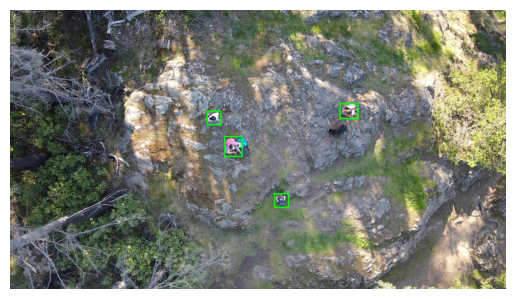

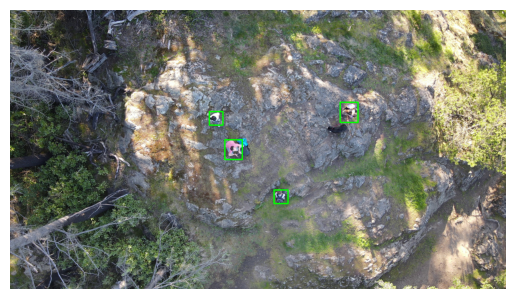

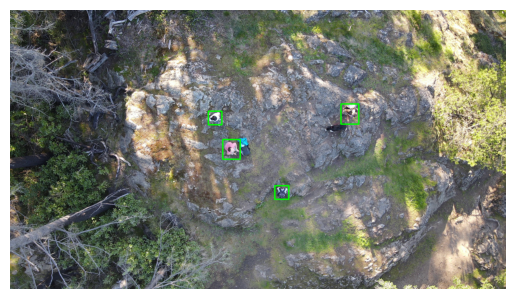

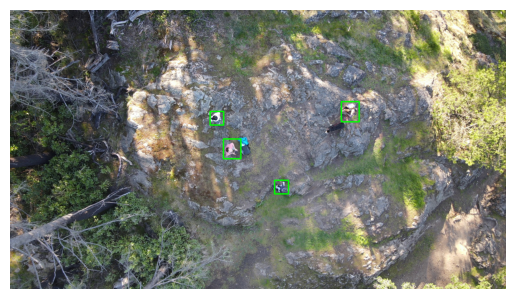

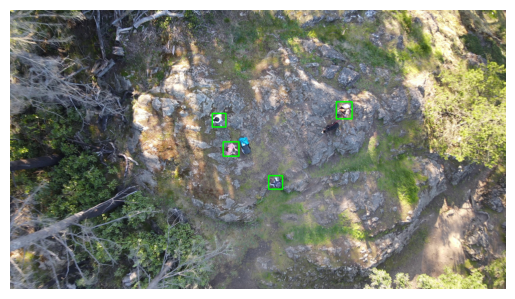

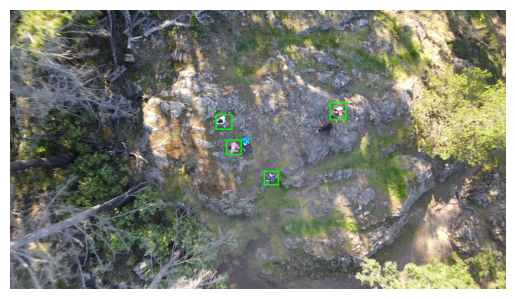

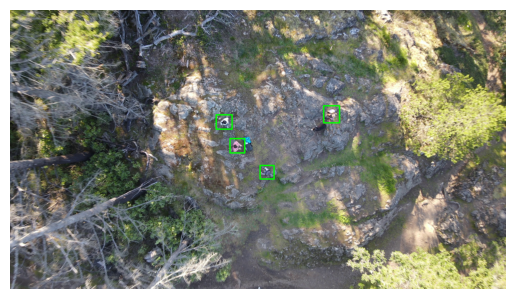

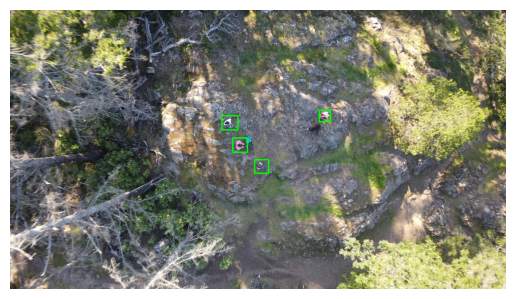

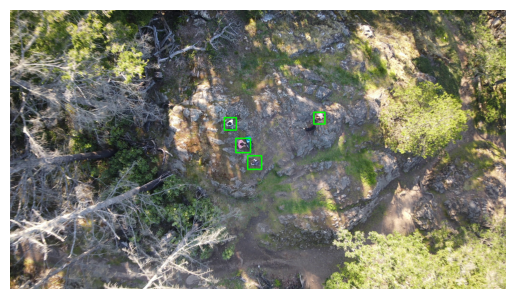

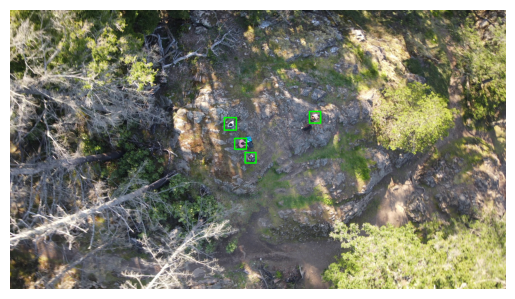

In [5]:
plot_images(VIS_img_files, VIS_label_files)

## Thermal Images

In [6]:
thermal_file_path = '/kaggle/input/mydataset/210417_MtErie_Enterprise_IR_0004'
IR_img_files, IR_label_files= classify(thermal_file_path)

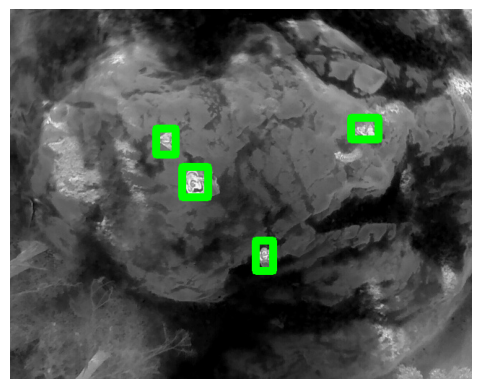

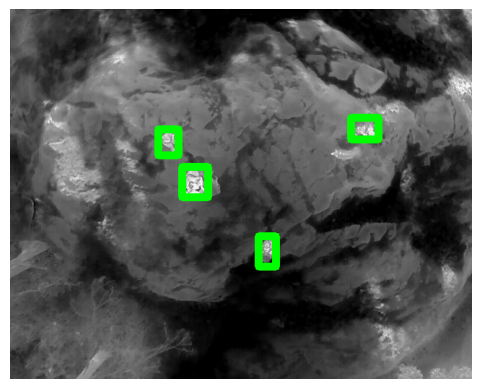

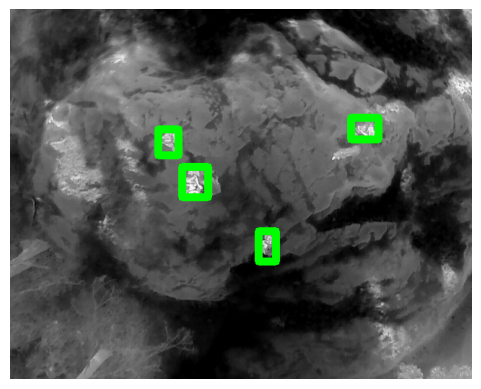

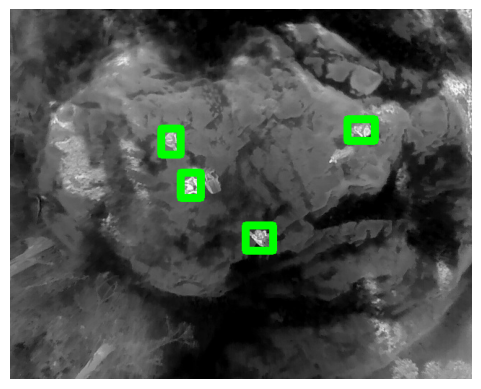

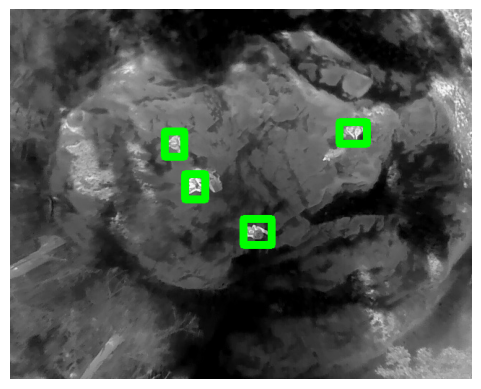

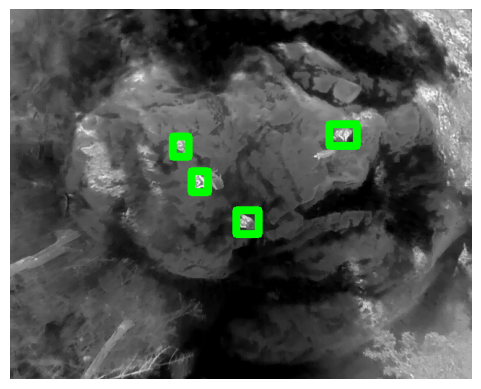

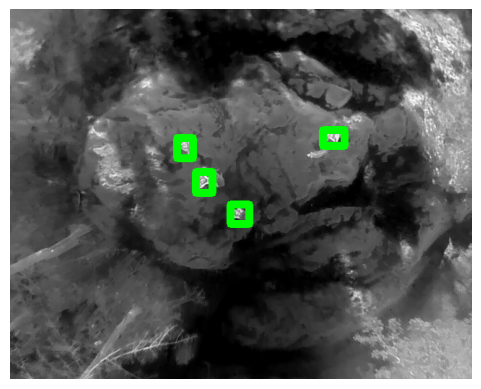

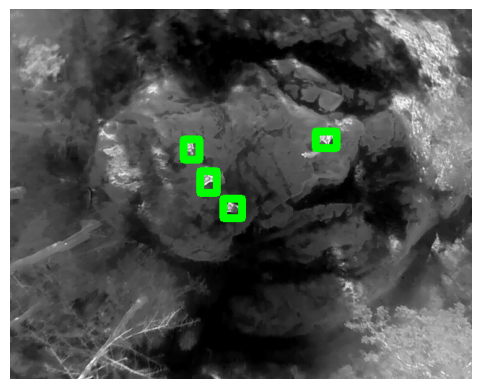

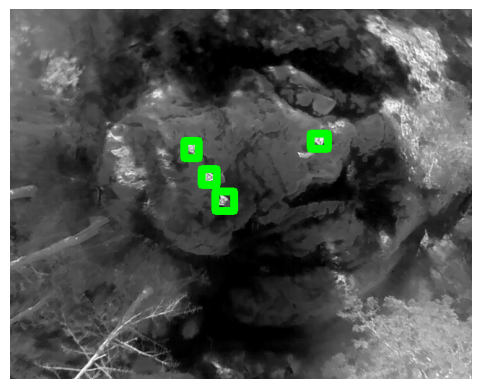

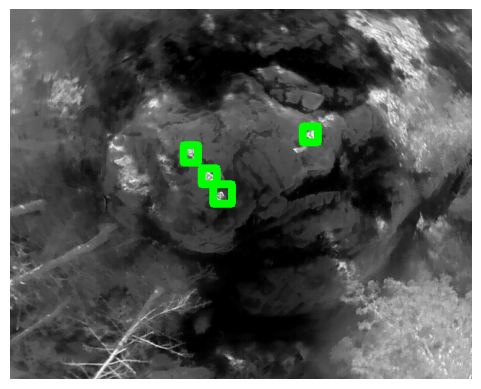

In [7]:
plot_images(IR_img_files, IR_label_files)

# Preprocessing

In [8]:
def standardization(img):
    pass

In [9]:
def augment_and_transform(img):
    pass

In [10]:
def filtering_and_smoothing(img):
    pass    

In [74]:
transform = {
    'train_crop': v2.Compose([
        v2.ToImage(),                                # Convert PIL to tensor
        v2.Resize((600, 600), antialias=True),       # Resize with antialiasing
        v2.RandomHorizontalFlip(p=0.5),              # More common to use p=0.5
        v2.ColorJitter(brightness=0.3, contrast=0.2,saturation =0.3),
        v2.RandomVerticalFlip(p=0.5),
        # v2.RandomRotation(degrees=(-90, 90)),        # Rotates both image and boxes
        v2.ToDtype(torch.float32, scale=True),       # Convert to float and scale to [0,1]
    ]),
    'test': v2.Compose([
        v2.ToImage(),
        v2.Resize((600, 600), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.Resize((600, 600), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
    ]),
}


In [82]:
class Dataset(Dataset):
    def __init__(self, img_files, label_files, transform=None):
        self.img_files = img_files
        self.label_files= label_files
        self.transform= transform
        
    def __len__(self):
        return len(self.img_files)

    
    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = self.label_files[idx]
        
        img = Image.open(img_file).convert("RGB")
        img_w, img_h= img.size
        
        
        bboxes = self.extract_bbox(label_file, img_h,img_w)
        bboxes = bboxes if bboxes else np.reshape(bboxes,(0,4))
        bboxes= tv_tensors.BoundingBoxes(bboxes,format="XYXY", canvas_size=(img_h,img_w))
        
        labels = torch.ones(bboxes.shape[0], dtype=torch.int64)
        target = {"boxes": bboxes, "labels": labels}
    
        if self.transform:
            img, target = self.transform(img, target)
            
        
        return img, target
        
    def extract_bbox(self, label_file, img_h,img_w):
        bboxes=[]
        with open(label_file,'r') as f:
            lines= f.readlines()
            for line in lines:
                bbox = line.split(' ')
                x_center = float(bbox[1]) * img_w
                y_center = float(bbox[2]) * img_h
                w = float(bbox[3]) * img_w
                h = float(bbox[4]) * img_h
                
                x_min = int(x_center - w / 2)
                y_min = int(y_center - h / 2)
                x_max = int(x_center + w / 2)
                y_max = int(y_center + h / 2)
                bboxes.append([x_min,y_min,x_max,y_max])
        
        return bboxes
        
    
                

In [76]:
img_files = VIS_img_files + IR_img_files
labels =  VIS_label_files + IR_label_files

In [77]:
img_files_train, img_files_val, labels_train, labels_val = train_test_split(
    img_files, labels, test_size=0.3, random_state=42, shuffle=True
)

In [83]:
train_ds = Dataset(img_files_train, labels_train, transform['train_crop'])
val_ds = Dataset(img_files_val, labels_val, transform['val'])

## Check Dataset

In [72]:
def check(dataset, n_samples):
    for i in range(n_samples):
        img, target= dataset[i]
        boxes = target['boxes']
        boxes=boxes.detach().numpy().astype(np.int32)
        sample=img.permute(1,2,0).numpy().copy()
        for box in boxes:
            sample=cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(220, 0, 0), 3)
        plt.imshow(sample)
        plt.axis('off')
        plt.show()
        
        
        

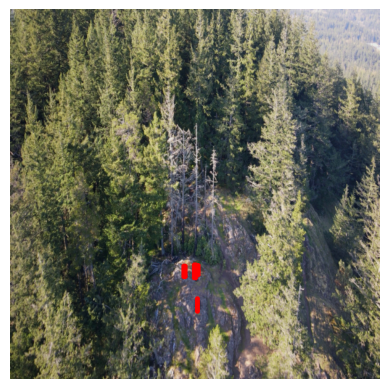

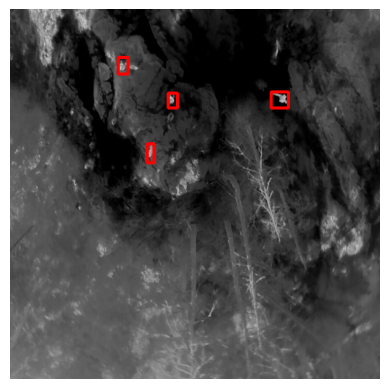

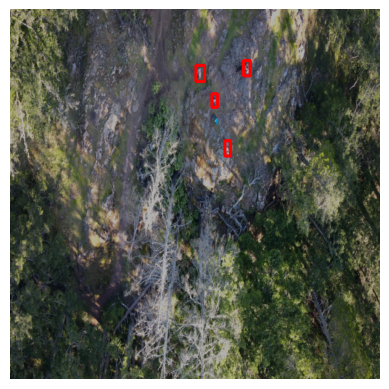

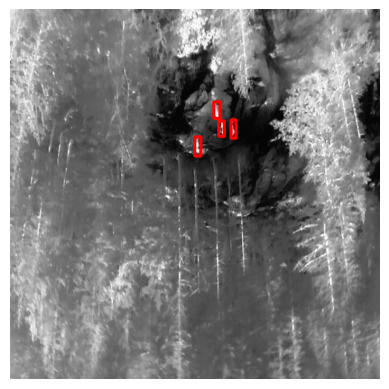

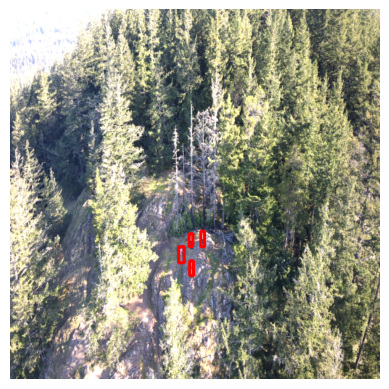

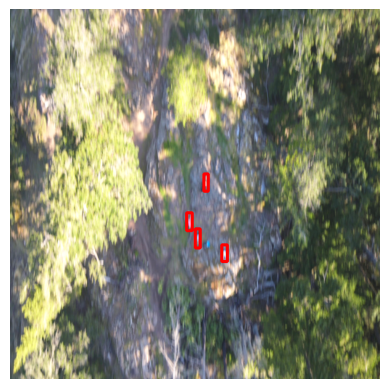

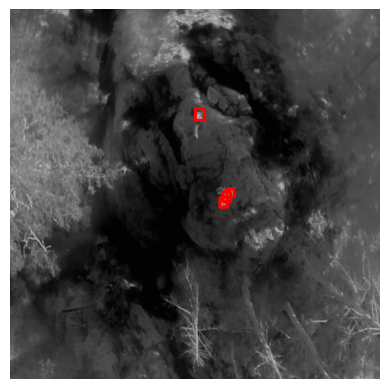

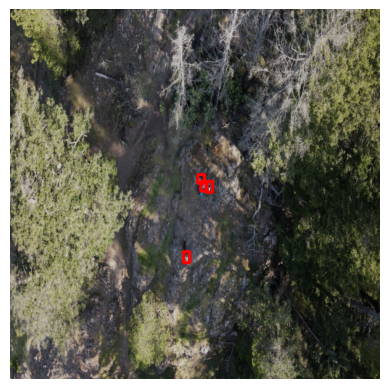

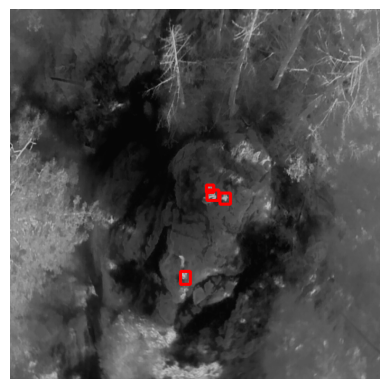

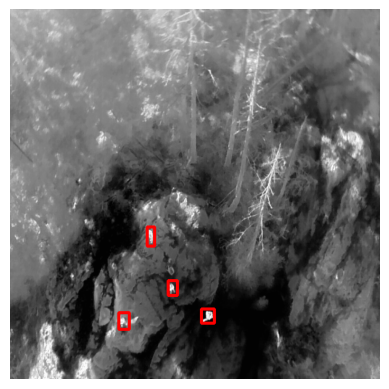

In [89]:
check(train_ds, 10)

In [ ]:
check(val_ds, 10)

# Dataloader

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Modeling

In [18]:
model= torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

In [19]:
model.backbone.requires_grad_(False)

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

In [20]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

backbone.body.conv1.weight False
backbone.body.layer1.0.conv1.weight False
backbone.body.layer1.0.conv2.weight False
backbone.body.layer1.0.conv3.weight False
backbone.body.layer1.0.downsample.0.weight False
backbone.body.layer1.1.conv1.weight False
backbone.body.layer1.1.conv2.weight False
backbone.body.layer1.1.conv3.weight False
backbone.body.layer1.2.conv1.weight False
backbone.body.layer1.2.conv2.weight False
backbone.body.layer1.2.conv3.weight False
backbone.body.layer2.0.conv1.weight False
backbone.body.layer2.0.conv2.weight False
backbone.body.layer2.0.conv3.weight False
backbone.body.layer2.0.downsample.0.weight False
backbone.body.layer2.1.conv1.weight False
backbone.body.layer2.1.conv2.weight False
backbone.body.layer2.1.conv3.weight False
backbone.body.layer2.2.conv1.weight False
backbone.body.layer2.2.conv2.weight False
backbone.body.layer2.2.conv3.weight False
backbone.body.layer2.3.conv1.weight False
backbone.body.layer2.3.conv2.weight False
backbone.body.layer2.3.conv3.

In [21]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
device= 'cuda'
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5,  weight_decay=0.1)
lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=8, threshold=0.0001)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [24]:
best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

In [25]:
def eval(model, val_loader, device, current_lr, lr_scheduler):
    total_loss=[]
    global best_validation_loss, best_weights
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, targets)
            loss = sum( loss for loss in loss_dict.values())
            total_loss.append(loss)
            
    lr_scheduler.step(loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best model weights")
        model.load_state_dict(best_weights)
    
    if sum(total_loss)<best_validation_loss:
        print("Loading best model weights")
        best_validation_loss=sum(total_loss)
        best_weights=copy.deepcopy(model.state_dict())
    
    return total_loss
     
        
        
        

In [26]:
def train(model, train_loader, val_loader, optimizer, lr_scheduler, epochs, device):
    total_training_loss= []
    total_valid_loss=[]
    model.train()
    
    for epoch in range(epochs):
        epoch_loss=[]
        current_lr=get_lr(optimizer)
        for imgs, targets in train_loader:
            optimizer.zero_grad()
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, targets)
            losses=sum(loss for loss in loss_dict.values())
            epoch_loss.append(losses.item())
            losses.backward()    
            optimizer.step()
        epoch_loss=sum(epoch_loss)/len(epoch_loss)  
        total_training_loss.append(epoch_loss)
        
        val_loss= eval(model, val_loader, device, current_lr, lr_scheduler)
        val_loss= sum(val_loss)/len(val_loss)
        total_valid_loss.append(val_loss)
        print(f"Epoch {epoch+1} \nTraining Loss: {epoch_loss} \nValidation Loss: {val_loss}")
        print("*"*50)
    
    print(f"Average Training: {sum(total_training_loss)/len(total_training_loss)}")
    print(f"Average Validation: {sum(total_valid_loss)/len(total_valid_loss)}")

        
            
    

In [27]:
train(model,train_loader, val_loader, optimizer, lr_scheduler, 20, device)


Epoch 1 
Training Loss: 40.56544876098633 
Validation Loss: 38.948997497558594
**************************************************
Epoch 2 
Training Loss: 38.79081964492798 
Validation Loss: 38.153778076171875
**************************************************
Epoch 3 
Training Loss: 37.96216599146525 
Validation Loss: 37.35477066040039
**************************************************
Epoch 4 
Training Loss: 38.04057296117147 
Validation Loss: 36.37266159057617
**************************************************
Epoch 5 
Training Loss: 37.491156260172524 
Validation Loss: 35.644439697265625
**************************************************
Epoch 6 
Training Loss: 35.53774627049764 
Validation Loss: 34.9430046081543
**************************************************
Epoch 7 
Training Loss: 35.68160104751587 
Validation Loss: 34.526519775390625
**************************************************
Epoch 8 
Training Loss: 34.53177833557129 
Validation Loss: 34.35466003417969
***************

# Save Weights

In [ ]:
torch.sasve(best_weights,"rcnn_pretrained.pth")

# Implementation

In [ ]:
model.load_state_dict(torch.load(best_weights))


In [ ]:
img_path="/kaggle/input/test_dataset"
img_files = [os.path.join(,img_path,img_file) for img_file in os.listdir(img_path)]


In [ ]:
def show(img,boxes,ax,color=(255,0,0)):
    
    boxes=boxes.detach().cpu().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()
    
    for box in boxes:
        sample = cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),color, 3)
    
    ax.axis("off");
    ax.imshow(sample);

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

for img_file in img_files:
    
    img = Image.open(img_file).convert("RGB")
    img = transform['test'](img)
    predictions=model(img)
    
    
    #non-max suppression
    #threshold=0.5
    #iou_threshold=0.8
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    pp_boxes=predictions["boxes"][predictions["scores"]>=0.6]
    scores=predictions["scores"][predictions["scores"]>=0.6]
    nms=torchvision.ops.nms(pp_boxes,scores,iou_threshold=0.1)
    pp_boxes=pp_boxes[nms]

    show(img,pp_boxes,axes[i,1]);
    